# Notebook for Developing Experiments on CovType Data Set

In [1]:
import os
import sys

sys.path.append(os.path.dirname(os.getcwd()))

import scipy
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier


from test_harness.datasets.dataset import Dataset
from test_harness.experiments.baseline_experiment import BaselineExperiment
from test_harness.experiments.topline_experiment import ToplineExperiment
from test_harness.experiments.response_uncertainty_experiment import (
    UncertaintyKSExperiment,
)
from test_harness.experiments.margin_uncertainty_experiment import (
    UncertaintyX2Experiment,
)
from test_harness.utils.utils import (
    plot_experiment_error,
    plot_multiple_experiments,
    aggregate_experiment_metrics,
    plot_response_distributions_bysplit,
    plot_margin_distributions_bysplit,
    format_experimental_scores,
    calculate_split_window_distances,
)

%load_ext nb_black
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

## Load Data

In [2]:
with open("../data/covtype_induced_drift_forward_norm.pkl", "rb") as f:
    drift_df, change_points = pickle.load(f)

<IPython.core.display.Javascript object>

**NEED TO**
 - Check distribution of class labels in each "concept" that I've created...

## Experiments

### Prepare Test Harness

In [3]:
# specify columns and if categorical
col_names = [
    ("elevation", False),
    ("aspect", False),
    ("slope", False),
    ("horizontal_dist_to_hydrology", False),
    ("vertical_dist_to_hydrology", False),
    ("horizontal_dist_to_roadways", False),
    ("hillshade_9am", False),
    ("hillshade_noon", False),
    ("hillshade_3pm", False),
    ("horizontal_dist_to_fire_points", False),
]
wilderness_area_cols = [(f"wilderness_area_{i+1}", True) for i in range(4)]
col_names = col_names + wilderness_area_cols + [("cover_type", True)]

<IPython.core.display.Javascript object>

In [4]:
column_mapping = {
    "target": "cover_type",
    "numerical_features": [col for col, iscat in col_names if not iscat],
    "categorical_features": [col for col, iscat in col_names if iscat][:-1],
}

# 17500
CT_dataset = Dataset(
    full_df=drift_df, column_mapping=column_mapping, window_size=17500 * 3
)

model = RandomForestClassifier(n_estimators=5, random_state=42, max_depth=5)
param_grid = {"clf__n_estimators": [3, 5], "clf__max_depth": [3, 5]}

<IPython.core.display.Javascript object>

### Run

In [5]:
baseline = BaselineExperiment(model=model, dataset=CT_dataset, param_grid=param_grid)
baseline.run()

topline = ToplineExperiment(model=model, dataset=CT_dataset, param_grid=param_grid)
topline.run()

uncertainty_ks = UncertaintyKSExperiment(
    model=model,
    dataset=CT_dataset,
    param_grid=param_grid,
    k=10,
    significance_thresh=0.001,
)
uncertainty_ks.run()

uncertainty_x2 = UncertaintyX2Experiment(
    model=model,
    dataset=CT_dataset,
    param_grid=param_grid,
    k=10,
    significance_thresh=0.001,
    margin_width=0.1,
)
uncertainty_x2.run()

Dataset index of split end: 105000
GETTING REFERENCE DISTRIBUTION FOR WINDOW: 0
Shape of k-fold preds: (0,)
Shape of k-fold preds: (5250,)
Shape of k-fold preds: (10500,)
Shape of k-fold preds: (15750,)
Shape of k-fold preds: (21000,)
Shape of k-fold preds: (26250,)
Shape of k-fold preds: (31500,)
Shape of k-fold preds: (36750,)
Shape of k-fold preds: (42000,)
Shape of k-fold preds: (47250,)
FINAL SHAPE kfold preds: (52500,)
GETTING DETECTION DISTRIBUTION FOR WINDOW: 1
Dataset Split: 1
REFERENCE STATS: DescribeResult(nobs=52500, minmax=(0.07199405272071246, 0.9469117950604169), mean=0.5727248652356196, variance=0.04526935646255182, skewness=-0.24570261594273402, kurtosis=-1.4419600428618804)
DETECTION STATS: DescribeResult(nobs=52500, minmax=(0.07095048719745035, 0.9258067629461451), mean=0.5748638578067388, variance=0.044738955071683774, skewness=-0.23977019532187405, kurtosis=-1.4164458761727812)
KS Test Result: FAILED | KstestResult(statistic=0.03434285714285712, pvalue=2.4698433240

GETTING REFERENCE DISTRIBUTION FOR WINDOW: 1
GETTING DETECTION DISTRIBUTION FOR WINDOW: 2
X2 Test Result: FAILED | Power_divergenceResult(statistic=1430.309961245028, pvalue=0.0)

Dataset index of split end: 210000
GETTING REFERENCE DISTRIBUTION FOR WINDOW: 2
GETTING DETECTION DISTRIBUTION FOR WINDOW: 3
X2 Test Result: PASSED | Power_divergenceResult(statistic=10.052184984045274, pvalue=0.001521673555609726)

Dataset index of split end: 262500
GETTING DETECTION DISTRIBUTION FOR WINDOW: 4
X2 Test Result: PASSED | Power_divergenceResult(statistic=5.121594225699833, pvalue=0.023629898439769117)

Dataset index of split end: 315000
GETTING DETECTION DISTRIBUTION FOR WINDOW: 5
X2 Test Result: PASSED | Power_divergenceResult(statistic=4.685919858674327, pvalue=0.030410777385355695)

Dataset index of split end: 367500
GETTING DETECTION DISTRIBUTION FOR WINDOW: 6
X2 Test Result: PASSED | Power_divergenceResult(statistic=0.2869833073328502, pvalue=0.5921602150223118)

Dataset index of split end:

<IPython.core.display.Javascript object>

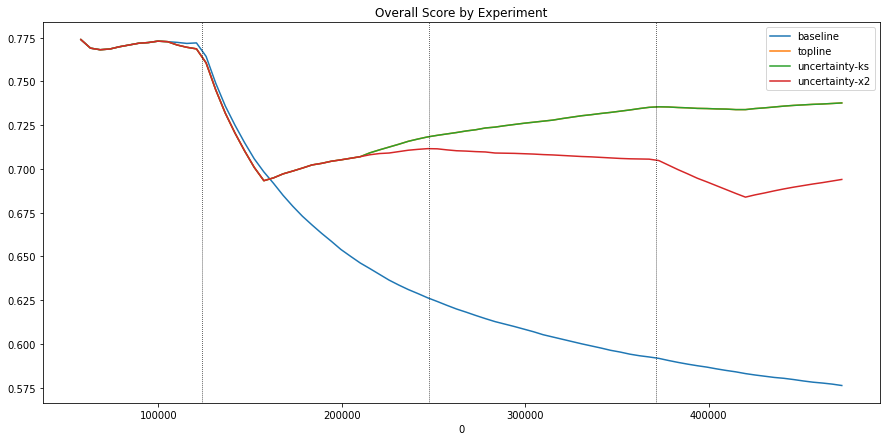

,times_retrained,percent_total_labels,total_train_time
experiment,,,
baseline,1,0.1060,0.15
topline,9,0.9543,1.27
uncertainty-ks,9,0.9543,1.35
uncertainty-x2,5,0.5302,0.77


<IPython.core.display.Javascript object>

In [7]:
exps = [baseline, topline, uncertainty_ks, uncertainty_x2]
plot_multiple_experiments(exps, change_points)
aggregate_experiment_metrics(exps)

### Uncertainty KS Debug

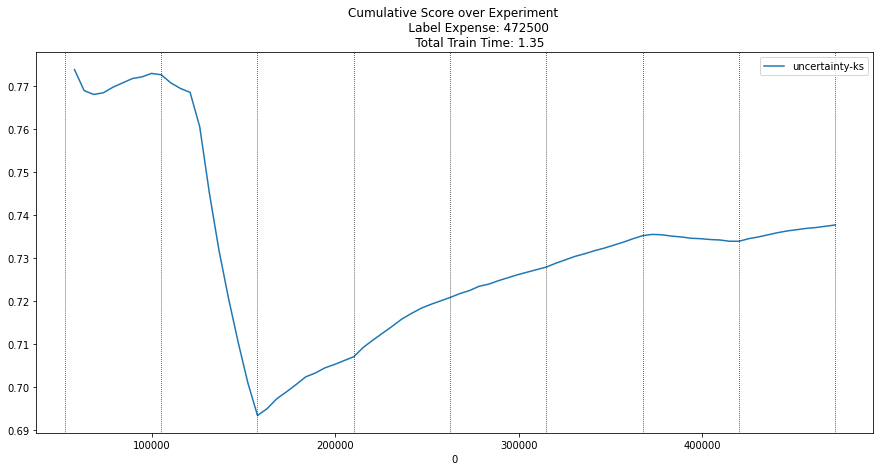

<IPython.core.display.Javascript object>

In [8]:
plot_experiment_error(uncertainty_ks)

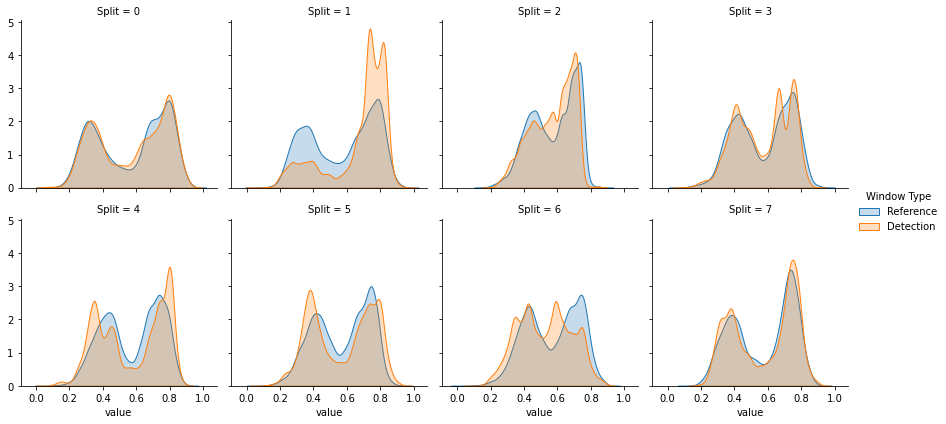

<IPython.core.display.Javascript object>

In [9]:
plot_response_distributions_bysplit(uncertainty_ks)

### Margin Uncertainty Debug

Same Distribution: False
Expected Distribution: [0.9348380952380952, 0.06516190476190477]
Observed Distribution: [0.9312190476190476, 0.06878095238095239]
Percent change in margin: 0.0555
Number in Margin: Before 3421 | After 3611 | Difference -190
Chi-Square Results: Power_divergenceResult(statistic=11.288018847063524, pvalue=0.0007800888138293107)

Same Distribution: False
Expected Distribution: [0.9196190476190477, 0.08038095238095239]
Observed Distribution: [0.9644952380952381, 0.03550476190476191]
Percent change in margin: 0.5583
Number in Margin: Before 4220 | After 1864 | Difference 2356
Chi-Square Results: Power_divergenceResult(statistic=1430.309961245028, pvalue=0.0)

Same Distribution: True
Expected Distribution: [0.8010666666666667, 0.19893333333333332]
Observed Distribution: [0.8065904761904762, 0.1934095238095238]
Percent change in margin: 0.0278
Number in Margin: Before 10444 | After 10154 | Difference 290
Chi-Square Results: Power_divergenceResult(statistic=10.052184984

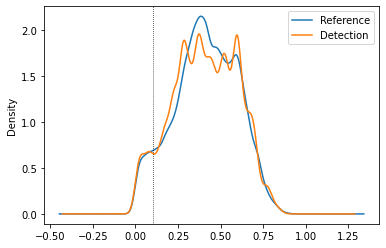

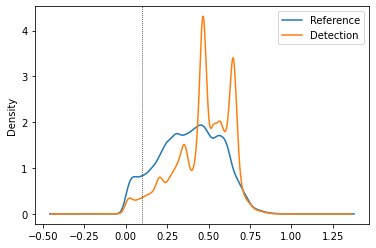

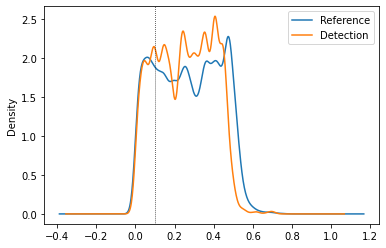

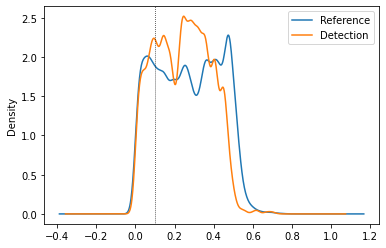

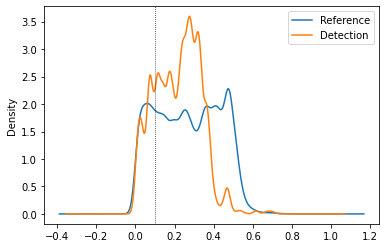

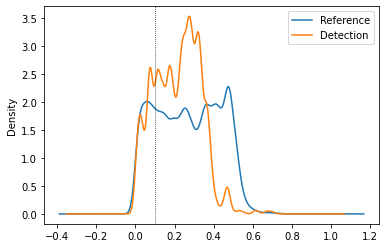

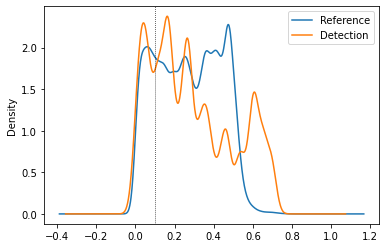

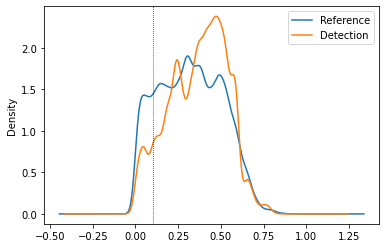

<IPython.core.display.Javascript object>

In [11]:
plot_margin_distributions_bysplit(uncertainty_x2)

## KS Test Deep Dive

### What is minimum reference window size for passing KS test?

Let's see what window size is needed to pass a KS test on the original dataset that has NO drift in it.

In [10]:
with open("../data/covtype_nodrift_norm.pkl", "rb") as f:
    nodrift_df = pickle.load(f)

nodrift_df = nodrift_df.reset_index(drop=True)

<IPython.core.display.Javascript object>

In [11]:
CT_nodrift_dataset = Dataset(
    full_df=nodrift_df, column_mapping=column_mapping, window_size=17500 * 5
)

uncertainty_ks_nodrift = UncertaintyKSExperiment(
    model=model,
    dataset=CT_nodrift_dataset,
    param_grid=param_grid,
    k=10,
    significance_thresh=0.001,
)
uncertainty_ks_nodrift.run()

Dataset index of split end: 175000
GETTING REFERENCE DISTRIBUTION FOR WINDOW: 0
Shape of k-fold preds: (0,)
Shape of k-fold preds: (8750,)
Shape of k-fold preds: (17500,)
Shape of k-fold preds: (26250,)
Shape of k-fold preds: (35000,)
Shape of k-fold preds: (43750,)
Shape of k-fold preds: (52500,)
Shape of k-fold preds: (61250,)
Shape of k-fold preds: (70000,)
Shape of k-fold preds: (78750,)
FINAL SHAPE kfold preds: (87500,)
GETTING DETECTION DISTRIBUTION FOR WINDOW: 1
Dataset Split: 1
REFERENCE STATS: DescribeResult(nobs=87500, minmax=(0.0687480431472266, 0.9661232413232493), mean=0.5716694540600071, variance=0.044276716703953035, skewness=-0.23478936056525296, kurtosis=-1.4388729888553327)
DETECTION STATS: DescribeResult(nobs=87500, minmax=(0.10440688772904749, 0.9429497475121849), mean=0.5733204625044183, variance=0.04164176792823418, skewness=-0.21044955749902566, kurtosis=-1.4150780727217487)
KS Test Result: FAILED | KstestResult(statistic=0.03832000000000002, pvalue=2.95673802022

<IPython.core.display.Javascript object>

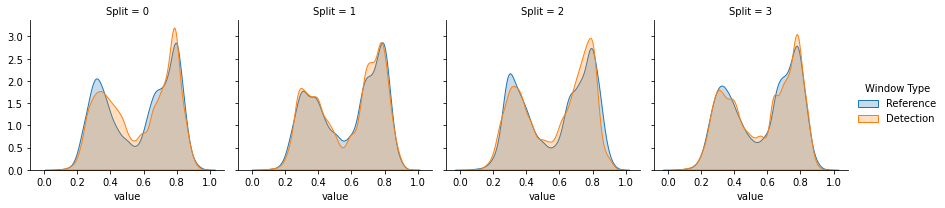

<IPython.core.display.Javascript object>

In [12]:
plot_response_distributions_bysplit(uncertainty_ks_nodrift)

**It looks like Kologorov-Smirnov is too sensitive/strict for our use case**

"A test has told you that two samples aren't from literally identical populations, but that's not what you actually care about. What you actually care about is up to you; it sounds like you care about how different the populations are. The solution is not to try to transform 𝑝-values ("when all you have is a hammer", etc.) but to use a more appropriate technique."

Even with the non-drifting dataset and huge windows, KS tests are too sensitive.

### Distance Metrics instead of KS test?

Maybe we could try calculating a distance instead of applying a check yes-no hypothesis test. The drawback here is that using distances requires us to then tune a threshold that indicates what level of distance is deemed acceptable - another hyperparameter to tune

In [29]:
calculate_split_window_distances(sqsi_mr, scipy.stats.entropy)

,Split,Distance
0,0,0.157516
1,1,0.139466
2,2,0.115135
3,3,0.065857
4,4,0.088850
5,5,0.083910
6,6,0.099678
7,7,0.087009
8,8,0.090778
9,9,0.095081


<IPython.core.display.Javascript object>

In [33]:
calculate_distances_window_distances(sqsi_mr, scipy.stats.wasserstein_distance)

,Split,Distance
0,0,0.009110
1,1,0.014873
2,2,0.067819
3,3,0.008488
4,4,0.004169
5,5,0.017748
6,6,0.041464
7,7,0.013371
8,8,0.003046
9,9,0.022570


<IPython.core.display.Javascript object>

In [32]:
calculate_distances_window_distances(sqsi_mr, scipy.spatial.distance.jensenshannon)

,Split,Distance
0,0,0.194725
1,1,0.185078
2,2,0.168608
3,3,0.127677
4,4,0.147346
5,5,0.143425
6,6,0.155732
7,7,0.145795
8,8,0.148882
9,9,0.152298


<IPython.core.display.Javascript object>

## Margin Uncertainty Approach with Chi-Squared Test

In [26]:
CT_nodrift_dataset = Dataset(
    full_df=nodrift_df, column_mapping=column_mapping, window_size=17500 * 3
)

uncertainty_x2_nodrift = UncertaintyX2Experiment(
    model=model,
    dataset=CT_nodrift_dataset,
    param_grid=param_grid,
    k=10,
    significance_thresh=0.001,
    margin_width=0.1,
)
uncertainty_x2_nodrift.run()

INFO:test_harness.experiments.margin_uncertainty_experiment:-------------------- Started Response Margin Uncertainty Experiment Run --------------------
INFO:test_harness.experiments.baseline_experiment:Trained Model at Index: 0 | GridsearchCV: True
INFO:test_harness.experiments.baseline_experiment:GSCV Best Params: {'clf__max_depth': 5, 'clf__n_estimators': 5}
INFO:test_harness.experiments.baseline_experiment:Train Score: 0.7702904761904763 | GSCV Test Score: 0.7675619047619048
INFO:test_harness.experiments.margin_uncertainty_experiment:Need to calculate Reference response distribution? - True
INFO:test_harness.experiments.baseline_experiment:Reference Evaluation at Window Start: 52500
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 52500 - 57750 | 1/10 | 0.7739
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 57750 - 63000 | 2/10 | 0.769


Dataset index of split end: 105000


INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 63000 - 68250 | 3/10 | 0.7681
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 68250 - 73500 | 4/10 | 0.7685
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 73500 - 78750 | 5/10 | 0.7698
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 78750 - 84000 | 6/10 | 0.7708
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 84000 - 89250 | 7/10 | 0.7718
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 89250 - 94500 | 8/10 | 0.7722
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 94500 - 99750 | 9/10 | 0.773
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 99750 - 105000 | 10/10 | 0.7727


GETTING REFERENCE DISTRIBUTION FOR WINDOW: 0


INFO:test_harness.experiments.margin_uncertainty_experiment:KS Test: Power_divergenceResult(statistic=11.288018847063524, pvalue=0.0007800888138293107)


GETTING DETECTION DISTRIBUTION FOR WINDOW: 1


INFO:test_harness.experiments.baseline_experiment:Trained Model at Index: 1 | GridsearchCV: True
INFO:test_harness.experiments.baseline_experiment:GSCV Best Params: {'clf__max_depth': 5, 'clf__n_estimators': 5}
INFO:test_harness.experiments.baseline_experiment:Train Score: 0.7696523809523809 | GSCV Test Score: 0.7680380952380952
INFO:test_harness.experiments.margin_uncertainty_experiment:Need to calculate Reference response distribution? - True
INFO:test_harness.experiments.baseline_experiment:Reference Evaluation at Window Start: 105000
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 105000 - 110250 | 1/10 | 0.7708
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 110250 - 115500 | 2/10 | 0.7695


X2 Test Result: FAILED | Power_divergenceResult(statistic=11.288018847063524, pvalue=0.0007800888138293107)

Dataset index of split end: 157500


INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 115500 - 120750 | 3/10 | 0.7686
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 120750 - 126000 | 4/10 | 0.7677
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 126000 - 131250 | 5/10 | 0.7673
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 131250 - 136500 | 6/10 | 0.7665
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 136500 - 141750 | 7/10 | 0.766
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 141750 - 147000 | 8/10 | 0.7653
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 147000 - 152250 | 9/10 | 0.7654
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 152250 - 157500 | 10/10 | 0.7652


GETTING REFERENCE DISTRIBUTION FOR WINDOW: 1


INFO:test_harness.experiments.margin_uncertainty_experiment:KS Test: Power_divergenceResult(statistic=0.0834881045402608, pvalue=0.7726249345769923)
INFO:test_harness.experiments.margin_uncertainty_experiment:Need to calculate Reference response distribution? - False
INFO:test_harness.experiments.baseline_experiment:Reference Evaluation at Window Start: 157500
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 157500 - 162750 | 1/10 | 0.7649
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 162750 - 168000 | 2/10 | 0.7649


GETTING DETECTION DISTRIBUTION FOR WINDOW: 2
X2 Test Result: PASSED | Power_divergenceResult(statistic=0.0834881045402608, pvalue=0.7726249345769923)

Dataset index of split end: 210000


INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 168000 - 173250 | 3/10 | 0.7648
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 173250 - 178500 | 4/10 | 0.7648
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 178500 - 183750 | 5/10 | 0.765
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 183750 - 189000 | 6/10 | 0.7645
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 189000 - 194250 | 7/10 | 0.7644
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 194250 - 199500 | 8/10 | 0.7643
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 199500 - 204750 | 9/10 | 0.7639
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 204750 - 210000 | 10/10 | 0.7639
INFO:test_harness.experiments.margin_uncertainty

GETTING DETECTION DISTRIBUTION FOR WINDOW: 3
X2 Test Result: PASSED | Power_divergenceResult(statistic=2.374772751367418, pvalue=0.12330954078506305)

Dataset index of split end: 262500


INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 220500 - 225750 | 3/10 | 0.763
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 225750 - 231000 | 4/10 | 0.7631
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 231000 - 236250 | 5/10 | 0.7631
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 236250 - 241500 | 6/10 | 0.7629
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 241500 - 246750 | 7/10 | 0.7626
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 246750 - 252000 | 8/10 | 0.7625
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 252000 - 257250 | 9/10 | 0.7623
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 257250 - 262500 | 10/10 | 0.7623
INFO:test_harness.experiments.margin_uncertainty

GETTING DETECTION DISTRIBUTION FOR WINDOW: 4
X2 Test Result: PASSED | Power_divergenceResult(statistic=1.055454556163297, pvalue=0.3042541895529445)

Dataset index of split end: 315000


INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 273000 - 278250 | 3/10 | 0.762
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 278250 - 283500 | 4/10 | 0.7615
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 283500 - 288750 | 5/10 | 0.7615
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 288750 - 294000 | 6/10 | 0.7615
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 294000 - 299250 | 7/10 | 0.7615
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 299250 - 304500 | 8/10 | 0.7613
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 304500 - 309750 | 9/10 | 0.7612
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 309750 - 315000 | 10/10 | 0.7612
INFO:test_harness.experiments.margin_uncertainty

GETTING DETECTION DISTRIBUTION FOR WINDOW: 5
X2 Test Result: PASSED | Power_divergenceResult(statistic=7.446932781523263, pvalue=0.006354464416971956)

Dataset index of split end: 367500


INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 325500 - 330750 | 3/10 | 0.7609
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 330750 - 336000 | 4/10 | 0.7607
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 336000 - 341250 | 5/10 | 0.7606
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 341250 - 346500 | 6/10 | 0.7603
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 346500 - 351750 | 7/10 | 0.7602
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 351750 - 357000 | 8/10 | 0.7602
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 357000 - 362250 | 9/10 | 0.7602
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 362250 - 367500 | 10/10 | 0.7602
INFO:test_harness.experiments.margin_uncertaint

GETTING DETECTION DISTRIBUTION FOR WINDOW: 6
X2 Test Result: PASSED | Power_divergenceResult(statistic=1.8181853877656797, pvalue=0.17752942691639237)

Dataset index of split end: 420000


INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 378000 - 383250 | 3/10 | 0.7599
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 383250 - 388500 | 4/10 | 0.7598
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 388500 - 393750 | 5/10 | 0.7597
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 393750 - 399000 | 6/10 | 0.7598
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 399000 - 404250 | 7/10 | 0.7597
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 404250 - 409500 | 8/10 | 0.7598
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 409500 - 414750 | 9/10 | 0.7598
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 414750 - 420000 | 10/10 | 0.76
INFO:test_harness.experiments.margin_uncertainty_

GETTING DETECTION DISTRIBUTION FOR WINDOW: 7
X2 Test Result: PASSED | Power_divergenceResult(statistic=0.35276300961610196, pvalue=0.5525532092335201)

Dataset index of split end: 472500


INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 430500 - 435750 | 3/10 | 0.7603
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 435750 - 441000 | 4/10 | 0.7603
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 441000 - 446250 | 5/10 | 0.7603
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 446250 - 451500 | 6/10 | 0.7603
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 451500 - 456750 | 7/10 | 0.7603
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 456750 - 462000 | 8/10 | 0.7602
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 462000 - 467250 | 9/10 | 0.7602
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 467250 - 472500 | 10/10 | 0.7603
INFO:test_harness.experiments.margin_uncertaint

GETTING DETECTION DISTRIBUTION FOR WINDOW: 8
X2 Test Result: PASSED | Power_divergenceResult(statistic=0.3720889597411623, pvalue=0.5418678022103016)



<IPython.core.display.Javascript object>

Same Distribution: False
Expected Distribution: [0.9348380952380952, 0.06516190476190477]
Observed Distribution: [0.9312190476190476, 0.06878095238095239]
Percent change in margin: 0.0555
Number in Margin: Before 3421 | After 3611 | Difference -190
Chi-Square Results: Power_divergenceResult(statistic=11.288018847063524, pvalue=0.0007800888138293107)

Same Distribution: True
Expected Distribution: [0.9196190476190477, 0.08038095238095239]
Observed Distribution: [0.9192761904761905, 0.08072380952380952]
Percent change in margin: 0.0043
Number in Margin: Before 4220 | After 4238 | Difference -18
Chi-Square Results: Power_divergenceResult(statistic=0.0834881045402608, pvalue=0.7726249345769923)

Same Distribution: True
Expected Distribution: [0.9196190476190477, 0.08038095238095239]
Observed Distribution: [0.9177904761904762, 0.08220952380952382]
Percent change in margin: 0.0227
Number in Margin: Before 4220 | After 4316 | Difference -96
Chi-Square Results: Power_divergenceResult(statistic

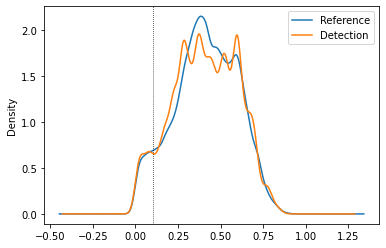

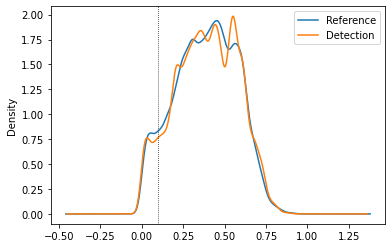

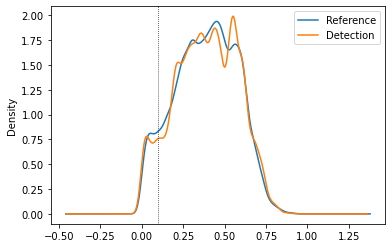

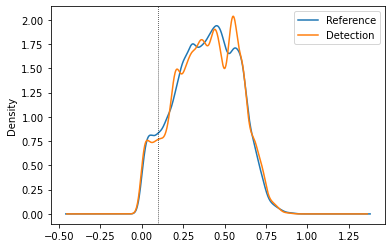

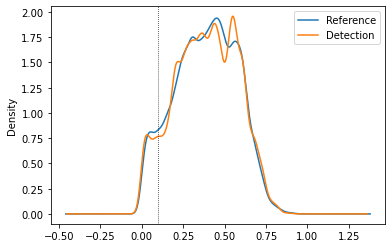

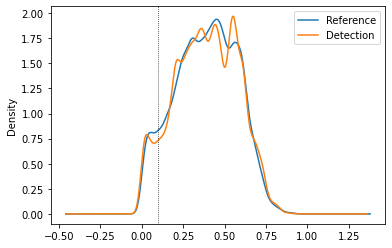

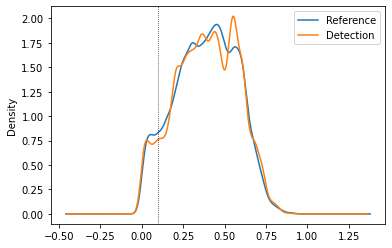

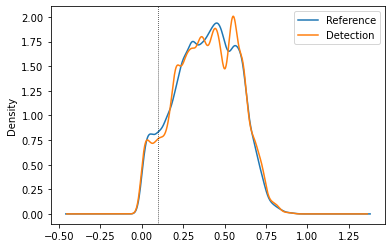

<IPython.core.display.Javascript object>

In [27]:
plot_margin_distributions_bysplit(uncertainty_x2_nodrift)

- Null Hypothesis (H0): Observed data follow the expected distribution
- Alternative Hypothesis (HA): Observed data do NOT follow the expected distribution
    
If p_value is less than 0.05, reject null hypothesis --> They are from different distributions